In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset and prep
df = pd.read_feather('../data/spotify_2000_2020.feather')
df['is_hit'] = (df['popularity'] > 80).astype(int)


## Step 1: Bootstrapping the Mean Popularity of Hit vs. Non-Hit Songs

We'll estimate the sampling distribution of the mean popularity for:

- Group A: Hit songs (is_hit == 1)

- Group B: Non-hit songs (is_hit == 0)

And compare them using bootstrapped confidence intervals.

### Step 1.1: Bootstrap Function + Resampling

In [2]:
# Split data
hit_popularity = df[df['is_hit'] == 1]['popularity'].values
non_hit_popularity = df[df['is_hit'] == 0]['popularity'].values

# Bootstrapping function
def bootstrap_means(data, n_bootstrap=5000):
    means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(sample))
    return np.array(means)

# Bootstrap samples
boot_hit = bootstrap_means(hit_popularity)
boot_non_hit = bootstrap_means(non_hit_popularity)


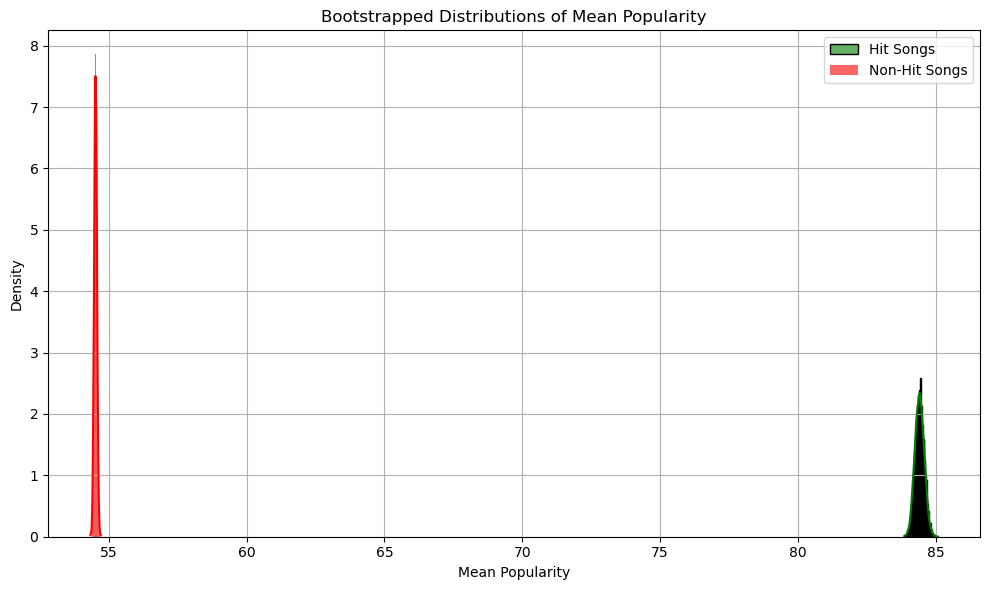

In [3]:
# Plot the bootstrapped means
plt.figure(figsize=(10, 6))
sns.histplot(boot_hit, color='green', label='Hit Songs', kde=True, stat='density', alpha=0.6)
sns.histplot(boot_non_hit, color='red', label='Non-Hit Songs', kde=True, stat='density', alpha=0.6)
plt.title('Bootstrapped Distributions of Mean Popularity')
plt.xlabel('Mean Popularity')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🟥 Red curve: Distribution of average popularity from non-hit songs

🟩 Green curve: Distribution of average popularity from hit songs

Each curve shows:

“What the average popularity might look like if we resampled from that group thousands of times.”

#### What This Means

- The green distribution (hits) is centered around ~84–85

- The red distribution (non-hits) is centered around ~54–55

They don’t overlap at all → there's a clear gap between the two groups

- Hit songs have much higher average popularity scores, by definition, but bootstrapping confirms this isn’t random

- The difference in means is stable and statistically meaningful

- This backs up what we saw earlier from hypothesis testing, now shown through distributional comparison

In [4]:
# Confidence intervals
ci_hit = np.percentile(boot_hit, [2.5, 97.5])
ci_non_hit = np.percentile(boot_non_hit, [2.5, 97.5])

print(f"95% CI for Hit Songs: {ci_hit}")
print(f"95% CI for Non-Hit Songs: {ci_non_hit}")

95% CI for Hit Songs: [84.0895977  84.74482759]
95% CI for Non-Hit Songs: [54.42376459 54.62591943]


#### Observation

- The 95% CI for hit songs' mean popularity is **[84.09, 84.74]**  
- For non-hit songs, it's **[54.42, 54.63]**
- These intervals are narrow and **do not overlap**, providing strong evidence that the **average popularity of hit songs is significantly higher** than that of non-hits.
- Bootstrapping confirms and visualizes this difference **without relying on parametric assumptions** like normality.

This supports earlier findings from hypothesis testing with an additional robust estimation method.



## Step 2: Bootstrap the Difference in Means

In [5]:
# Bootstrap difference in means
n_bootstrap = 5000
boot_diffs = []

for _ in range(n_bootstrap):
    sample_hit = np.random.choice(hit_popularity, size=len(hit_popularity), replace=True)
    sample_non_hit = np.random.choice(non_hit_popularity, size=len(non_hit_popularity), replace=True)
    diff = np.mean(sample_hit) - np.mean(sample_non_hit)
    boot_diffs.append(diff)

boot_diffs = np.array(boot_diffs)

# CI for the difference
ci_diff = np.percentile(boot_diffs, [2.5, 97.5])
print(f"95% CI for Mean Difference (Hit - Non-Hit): {ci_diff}")


95% CI for Mean Difference (Hit - Non-Hit): [29.54463422 30.24259721]


- The 95% confidence interval for the **difference in mean popularity** between hit and non-hit songs is:
  **[29.54, 30.24]**
- This means we can be 95% confident that **hit songs are, on average, 29.5 to 30.2 points more popular** than non-hits.
- Since the entire confidence interval is well above zero, this confirms the difference is **both statistically significant and practically meaningful**.
- Bootstrapping gives us this result without any assumption of normality or equal variance, further strengthening our earlier hypothesis testing conclusions.